## Laplace transforms in SymPy

The Laplace transform is 

$$\mathcal{L}\{f(t)\} = \int_0^\infty f(t) e^{-st} \mathrm{d}t $$

The Laplace transform is a transformation form the time-domain to the s-domain.
$t$ as the independent variable is replaced with $s$ as the independent variable.

#### Advantage:
- Differentiation with respect to time becomes a multiplication by $s$. 
- Integration with respect to time becomes a division by $s$.
- Convolution of two functions becomes the multiplication of the two functions.
- The Laplace transform is a linear operation: $\mathcal{L}\{a f_1(t) + b f_2(t)\} = a\mathcal{L}\{f_1(t)\} + b\mathcal{L}\{f_2(t)\}$

#### Limitations:
- The Laplace tranform only exists for functions for which the integral $\mathcal{L}\{f(t)\} = \int_0^\infty f(t) e^{-st} \mathrm{d}t $ is bounded.

In [120]:
import sympy
sympy.init_printing()

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline

Let's define some symbols to work with. 

In [122]:
s = sympy.symbols('s')
t = sympy.symbols('t', real=True)
a = sympy.symbols('a', real=True, positive=True)

### Direct evaluation

We start with a simple function

In [123]:
f = sympy.exp(-a*t)
f

We can evaluate the integral directly using `integrate`:

In [124]:
sympy.integrate(f*sympy.exp(-s*t), (t, 0, sympy.oo))

⎧       1                         π
⎪   ─────────      for │arg(s)│ ≤ ─
⎪     ⎛a    ⎞                     2
⎪   s⋅⎜─ + 1⎟                      
⎪     ⎝s    ⎠                      
⎪                                  
⎨∞                                 
⎪⌠                                 
⎪⎮  -a⋅t  -s⋅t                     
⎪⎮ ℯ    ⋅ℯ     dt     otherwise    
⎪⌡                                 
⎪0                                 
⎩                                  

### Library function

This works, but it is a bit cumbersome to have all the extra stuff in there. 

Sympy provides a function called `laplace_transform` which does this more efficiently. By default it will return conditions of convergence as well (recall this is an improper integral, with an infinite bound, so it will not always converge).

In [125]:
sympy.laplace_transform(f, t, s)

⎛  1           ⎞
⎜─────, 0, True⎟
⎝a + s         ⎠

If we want just the function, we can specify `noconds=True`.

In [126]:
F = sympy.laplace_transform(f, t, s, noconds=True)
F

We will find it useful to define a quicker version of this:

In [127]:
def L(f):
    return sympy.laplace_transform(f, t, s, noconds=True)

Inverses are simple as well,

In [128]:
def invL(F):
    return sympy.inverse_laplace_transform(F, s, t)

In [129]:
invL(F)

### What is that θ?

The unit step function is also known as the Heaviside step function. We will see this function often in inverse laplace transforms. It is typeset as $\theta(t)$ by sympy.

In [130]:
sympy.Heaviside(t)

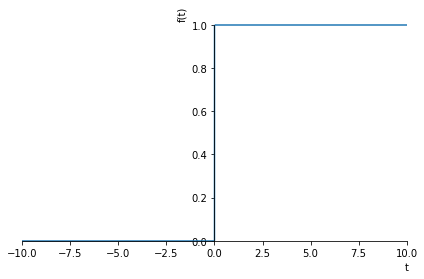

In [131]:
sympy.plot(sympy.Heaviside(t));

Look at the difference between $f$ and the inverse laplace transform we obtained, which contains the unit step to force it to zero before $t=0$.

In [132]:
invL(F).subs({a: 2})

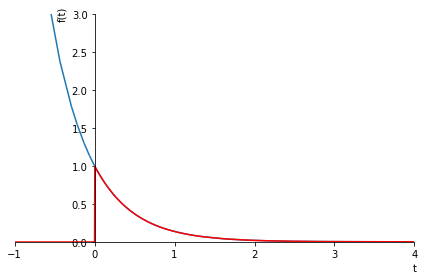

In [133]:
p = sympy.plot(f.subs({a: 2}), invL(F).subs({a: 2}), 
               xlim=(-1, 4), ylim=(0, 3), show=False)
p[1].line_color = 'red'
p.show()

### Reproducing standard transform table

Let's see if we can match the functions in the table

In [134]:
omega = sympy.Symbol('omega', real=True)
exp = sympy.exp
sin = sympy.sin
cos = sympy.cos
functions = [1,
         t,
         exp(-a*t),
         t*exp(-a*t),
         t**2*exp(-a*t),
         sin(omega*t),
         cos(omega*t),
         1 - exp(-a*t),
         exp(-a*t)*sin(omega*t),
         exp(-a*t)*cos(omega*t),
         ]
functions

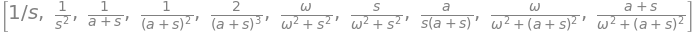

In [135]:
Fs = [L(f) for f in functions]
Fs

We can make a pretty good approximation of the table with a little help from pandas

In [136]:
from pandas import DataFrame

In [137]:
def makelatex(args):
    return ["$${}$$".format(sympy.latex(a)) for a in args]

In [138]:
DataFrame(list(zip(makelatex(functions), makelatex(Fs))))

,0,1
0,$$1$$,$$\frac{1}{s}$$
1,$$t$$,$$\frac{1}{s^{2}}$$
2,$$e^{- a t}$$,$$\frac{1}{a + s}$$
3,$$t e^{- a t}$$,$$\frac{1}{\left(a + s\right)^{2}}$$
4,$$t^{2} e^{- a t}$$,$$\frac{2}{\left(a + s\right)^{3}}$$
5,$$\sin{\left(\omega t \right)}$$,$$\frac{\omega}{\omega^{2} + s^{2}}$$
6,$$\cos{\left(\omega t \right)}$$,$$\frac{s}{\omega^{2} + s^{2}}$$
7,$$1 - e^{- a t}$$,$$\frac{a}{s \left(a + s\right)}$$
8,$$e^{- a t} \sin{\left(\omega t \right)}$$,$$\frac{\omega}{\omega^{2} + \left(a + s\right...
9,$$e^{- a t} \cos{\left(\omega t \right)}$$,$$\frac{a + s}{\omega^{2} + \left(a + s\right)...


## Inverse Laplace transforms

Now to solve the differential equation we will need to do the inverse Laplace transform to return to the time domain. However, it can be seen from the table above that there are not relationships for more complicated functions. This can be easily solved by converting higher order rational functions as sums of simpler ones. This will be achieved through partial fractions expansion.

$$G(s) = \frac{(s - z_1)(s - z_2)... (s - z_m)}{(s - p_1)(s - p_2)... (s - p_n)}$$

- $z_i$ are the zeros of the system.
- $p_i$ are the poles of the system.

The number of poles has to be greater than the number of zeros for the system to be full realisable. (i.e $m \leqslant n$)
If you make a function with more zeros than poles you will have a term $s$ that cannot be converted back to the time domain and therefore the system in not physically realisable.

In [139]:
G0 = ((s + 1)*(s + 2)* (s + 3)* (s+1))/((s + 4)*(s + 5)*(s + 6))

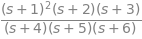

In [140]:
G0

In [141]:
G0.apart(s)

In [142]:
invL(s)

One can see that even the great sympy can help us here, so ensure that you always have more poles than zeros.

#### Real and different roots
These are systems where the characteristic equation can be factored into unique terms:

$$G(s) = \frac{s^2 - s - 6}{s^3 -2 s^2 - s + 2}$$
The characteristic equation can be written:
$$s^3 -2 s^2 - s + 2 = (s - 1)(s + 1)(s - 2)$$


In [143]:
G1 = (s**2 - s - 6)/(s**3 -2*s**2 - s + 2)
sympy.denom(G1.factor())

You can then determine the factor coefficients for the terms using the Heaviside expansion method:

$$G(s) = \frac{A}{s - 1} + \frac{B}{s + 1} + \frac{C}{s - 2}$$

However sympy can also do this for us:


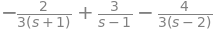

In [144]:
G1.apart(s)

#### Repeated factors

This is where a factor will appear more than once, the Heaviside expansion method will not be able to solve all three of the factors, so we will solve for two of them and the final factor we will solve by selecting a value for $s$ and solving the left and right side of the equations using the other two factor coefficients.

However, sympy can also help us here:

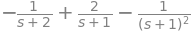

In [145]:
G2 = (s**2 + s*3 + 1)/((s+ 1)**2*(s + 2))
G2.apart(s)

#### Complex roots

The Heaviside expansion will work for functions with complex factors, sympy can also handle it:


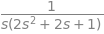

In [146]:
G3 = 1/(s*(2*s**2 + s*2 + 1))
G3

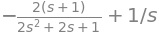

In [147]:
G3.apart(s)

We are left with a un-factored term, in this case we can do the following

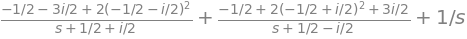

In [148]:
G3.apart(full = True).doit()

Now we can use know identities to convert from the Laplace domain back into the time domain.
But we could also use sympy:

In [149]:
invL(G1)

In [150]:
invL(G2)

In [151]:
invL(G3)

Let's try simplify that.

In [152]:
invL(G3).simplify()

That is far better.

### Dead time

Sympy is also able to handle dead time:

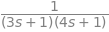

In [154]:
F = ( 1)/((4*s + 1)*(3*s + 1))
F

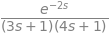

In [156]:
Fd = ( sympy.exp(-2*s))/((4*s + 1)*(3*s + 1))
Fd

In [157]:
f = invL(F)
fd = invL(Fd)

The plotting function in sympy is very handy to visualise the functions you are working with.

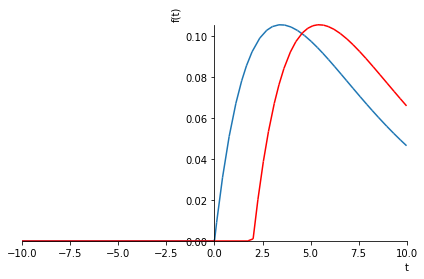

In [164]:
p = sympy.plot(f,fd,show = False)
p[1].line_color = 'red'
p.show()